# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [37]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 8
matplotlib.rcParams['ytick.labelsize'] = 8
matplotlib.rcParams['text.color'] = 'k'

from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [3]:
chicago_df = df.query("City == 'Chicago'")
chicago_df.head()

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
0      84654       60657  Chicago    IL  Chicago       Cook         1   
3      84616       60614  Chicago    IL  Chicago       Cook         4   
7      84640       60640  Chicago    IL  Chicago       Cook         8   
16     84646       60647  Chicago    IL  Chicago       Cook        17   
19     84620       60618  Chicago    IL  Chicago       Cook        20   

     1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
0   334200.0  335400.0  336500.0  ...  1005500  1007500  1007800  1009600   
3   498100.0  500900.0  503100.0  ...  1289800  1287700  1287400  1291500   
7   216500.0  216700.0  216900.0  ...   798000   787100   776100   774900   
16  122700.0  122800.0  122800.0  ...   459600   461400   464300   466500   
19  142600.0  143100.0  143400.0  ...   462700   461200   459900   459200   

    2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0   1013300  1018700  1024400  1030700  1033800  1030600  
3   1296600  1299000  1302700  1306400  1308500  1307000  
7    777900   777900   778500   780500   782800   782800  
16   467900   470600   474500   475100   472600   470200  
19   458700   457900   457400   459000   462500   464300  

[5 rows x 272 columns]

# Step 2: Data Preprocessing

In [4]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [5]:
to_drop = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
chicago_df = chicago_df.drop(to_drop, axis=1)
chicago_df.head()

RegionName   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
0        60657  334200.0  335400.0  336500.0  337600.0  338500.0  339500.0   
3        60614  498100.0  500900.0  503100.0  504600.0  505500.0  505700.0   
7        60640  216500.0  216700.0  216900.0  217000.0  217100.0  217200.0   
16       60647  122700.0  122800.0  122800.0  122700.0  122400.0  122000.0   
19       60618  142600.0  143100.0  143400.0  143300.0  142900.0  142200.0   

     1996-10   1996-11   1996-12  ...  2017-07  2017-08  2017-09  2017-10  \
0   340400.0  341300.0  342600.0  ...  1005500  1007500  1007800  1009600   
3   505300.0  504200.0  503600.0  ...  1289800  1287700  1287400  1291500   
7   217500.0  217900.0  218600.0  ...   798000   787100   776100   774900   
16  121500.0  120900.0  120500.0  ...   459600   461400   464300   466500   
19  141300.0  140100.0  139000.0  ...   462700   461200   459900   459200   

    2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0   1013300  1018700  1024400  1030700  1033800  1030600  
3   1296600  1299000  1302700  1306400  1308500  1307000  
7    777900   777900   778500   780500   782800   782800  
16   467900   470600   474500   475100   472600   470200  
19   458700   457900   457400   459000   462500   464300  

[5 rows x 266 columns]

In [6]:
get_datetimes(chicago_df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [7]:
dataframe_dict = {}
for i, g in chicago_df.groupby('RegionName'):
    g.to_csv('{}.csv'.format(i), header=True, index_label=False)
    
    dataframe_dict[i] = pd.read_csv('{}.csv'.format(i))

In [8]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [9]:
for zipcode in dataframe_dict.keys():
    dataframe_dict[zipcode] = melt_data(dataframe_dict[zipcode])

# Step 3: EDA and Visualization

In [10]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [11]:
#for zipcode in dataframe_dict.keys():
#    dataframe_dict[zipcode].plot(figsize=(15,6))
#    plt.xlabel("Year")
#    plt.ylabel("Value")
#    plt.title(f"AVG Home Values in {zipcode} from 1996 to 2017")
#    plt.show();

In [60]:
from statsmodels.tsa.stattools import adfuller
log_zips = {}

for zipcode, data in dataframe_dict.items():
    
    df_test = adfuller(np.log(dataframe_dict[zipcode]['value']))
    dfoutput = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', "#Observations"])
    for key, value in df_test[4].items():
        dfoutput['Critical Value(%s)'%key] = value
        
    if df_test[1] < .05:
        print(f'Results of Dickey-Fuller Test for {zipcode}: \n{df_test[1]} \n\n')
        log_zips[zipcode] = data
    else:
        continue

Results of Dickey-Fuller Test for 60605: 
0.04621757427163959 


Results of Dickey-Fuller Test for 60607: 
0.013637499844851865 


Results of Dickey-Fuller Test for 60608: 
0.002680726269388861 


Results of Dickey-Fuller Test for 60610: 
0.022949726035450226 


Results of Dickey-Fuller Test for 60613: 
0.014531226452624325 


Results of Dickey-Fuller Test for 60614: 
0.003606752889704816 


Results of Dickey-Fuller Test for 60622: 
0.03176380869784601 


Results of Dickey-Fuller Test for 60625: 
0.011940086509612972 


Results of Dickey-Fuller Test for 60626: 
0.011479547876069734 


Results of Dickey-Fuller Test for 60629: 
0.014809046417389851 


Results of Dickey-Fuller Test for 60630: 
0.009048624018449412 


Results of Dickey-Fuller Test for 60631: 
0.02003338106829901 


Results of Dickey-Fuller Test for 60632: 
0.03337286918465673 


Results of Dickey-Fuller Test for 60634: 
0.007560531808246128 


Results of Dickey-Fuller Test for 60638: 
0.013606444324121642 


Results of Dic

In [13]:
diff_zips = {}
for zipcode, data in dataframe_dict.items():
    
    df_test = adfuller(dataframe_dict[zipcode]['value'].diff().dropna())
    dfoutput = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', "#Observations"])
    for key, value in df_test[4].items():
        dfoutput['Critical Value(%s)'%key] = value
        #print(f'Results of Dickey-Fuller Test for {zipcode}: \n{dfoutput} \n\n')
    if df_test[1] < .05:
        diff_zips[zipcode] = data
    else:
        continue

In [14]:
rolmean_zips={}
for zipcode, data in dataframe_dict.items():
    exp_rolmean = np.log(dataframe_dict[zipcode]['value']).ewm(halflife = 2).mean()

    # Plot the original data with exp weighted average
    data_minus_exp_rolmean = np.log(dataframe_dict[zipcode]['value']) - exp_rolmean
    df_test = adfuller(data_minus_exp_rolmean)
    dfoutput = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', "#Observations"])
    for key, value in df_test[4].items():
        dfoutput['Critical Value(%s)'%key] = value
        #print(f'Results of Dickey-Fuller Test for {zipcode}: \n{dfoutput} \n\n')
    if df_test[1] < .05:
        rolmean_zips[zipcode] = data
    else:
        continue

In [15]:
from pylab import rcParams
#for zipcode in dataframe_dict.keys():
#    rcParams['figure.figsize'] = 18, 8
#    decomposition = sm.tsa.seasonal_decompose(np.log(dataframe_dict[zipcode].dropna()), model='additive')
#    fig = decomposition.plot()
#    plt.title(f'Time Series Decomposition for {zipcode}')
#    plt.show()

/Users/Allie/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/Allie/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/Allie/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


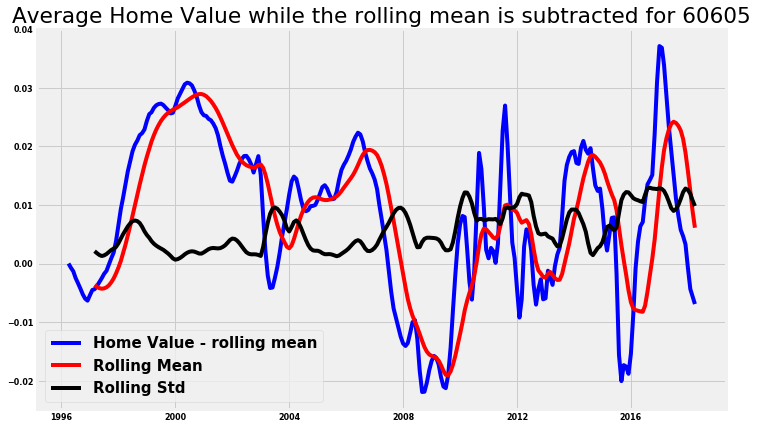

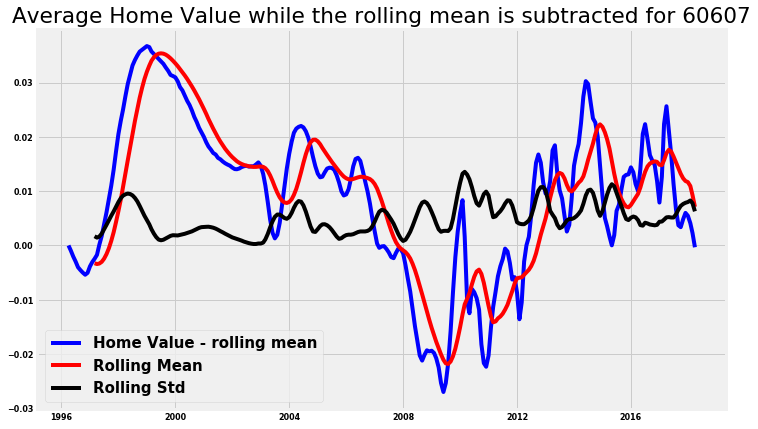

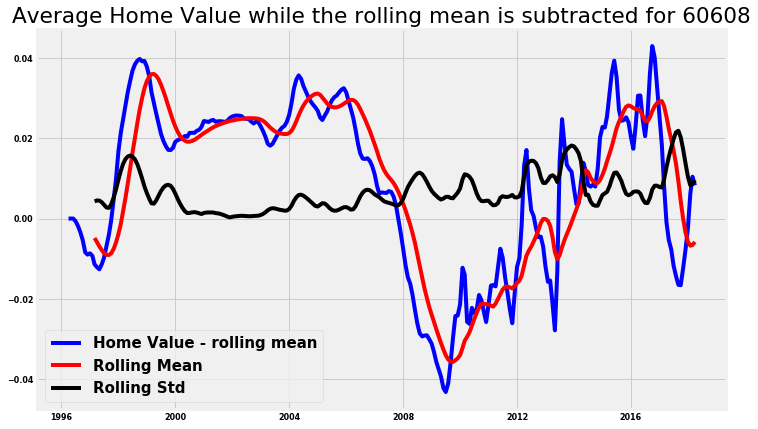

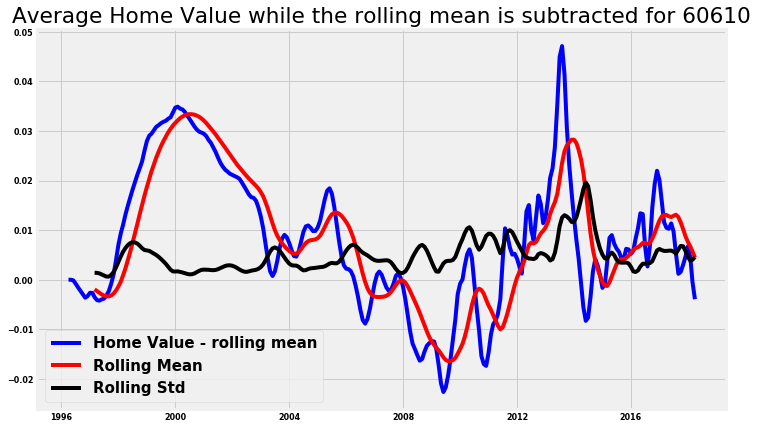

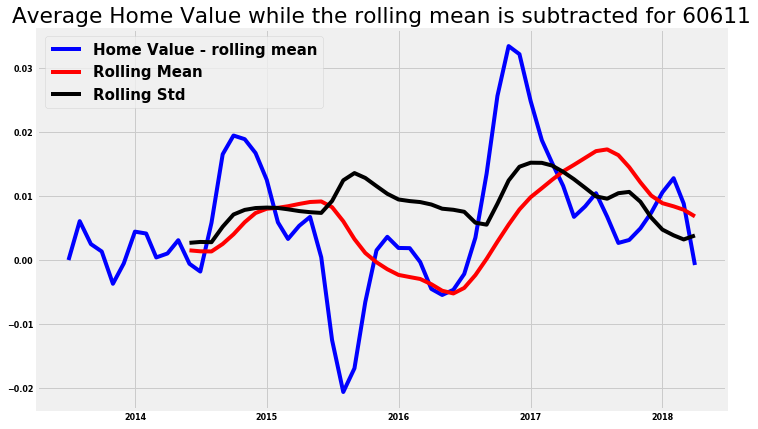

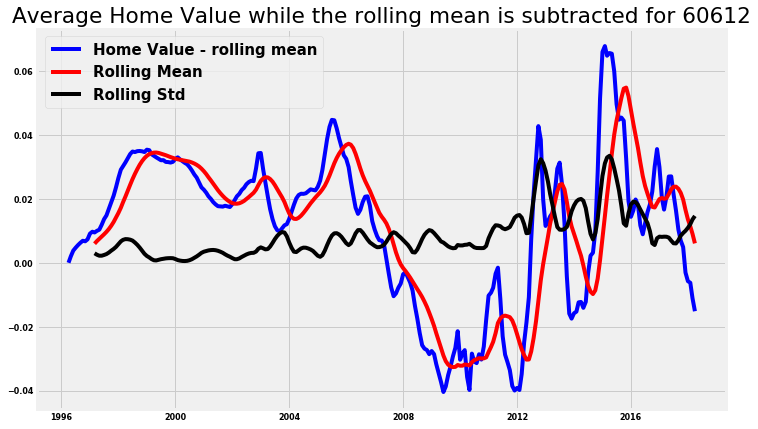

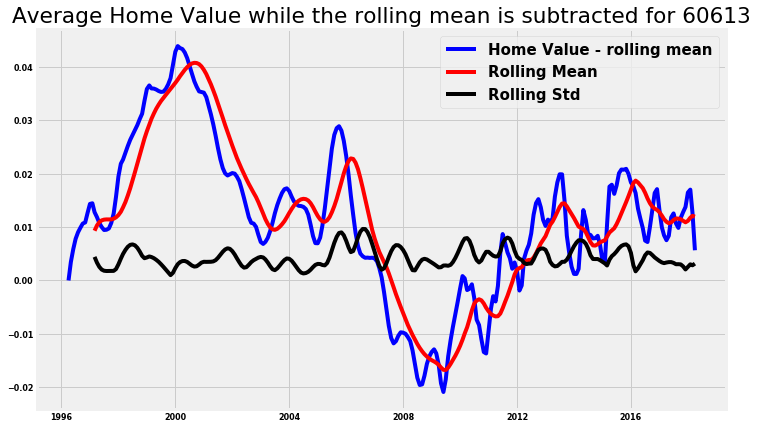

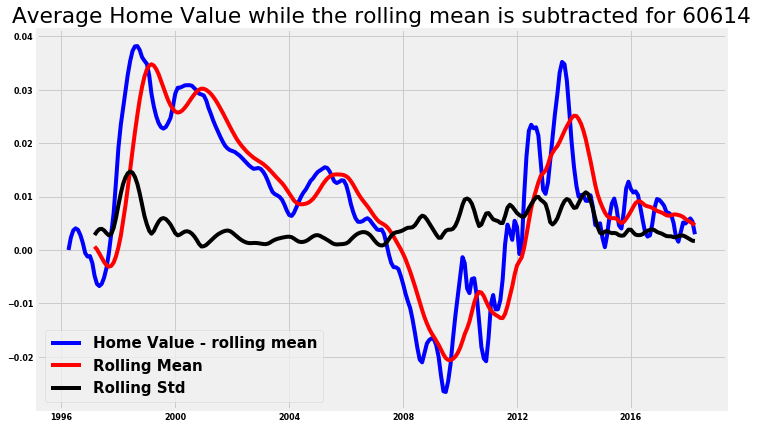

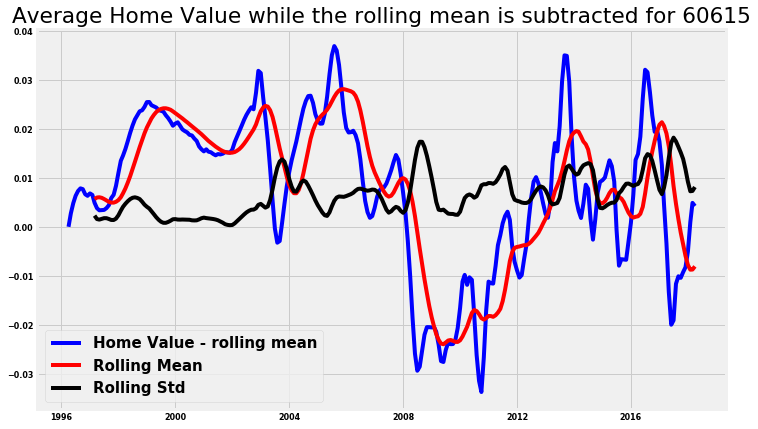

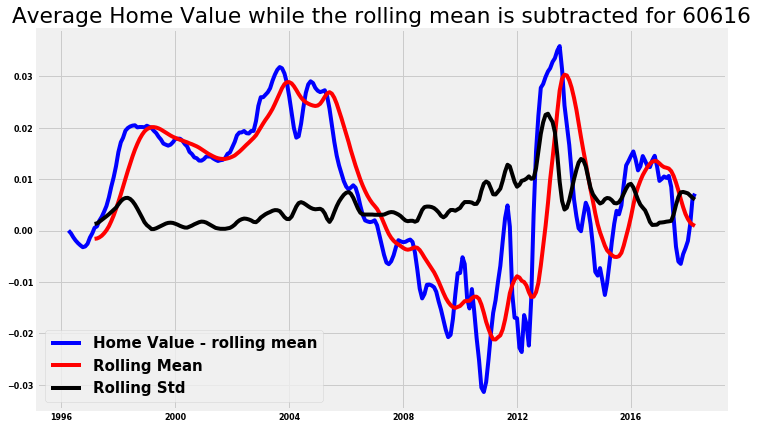

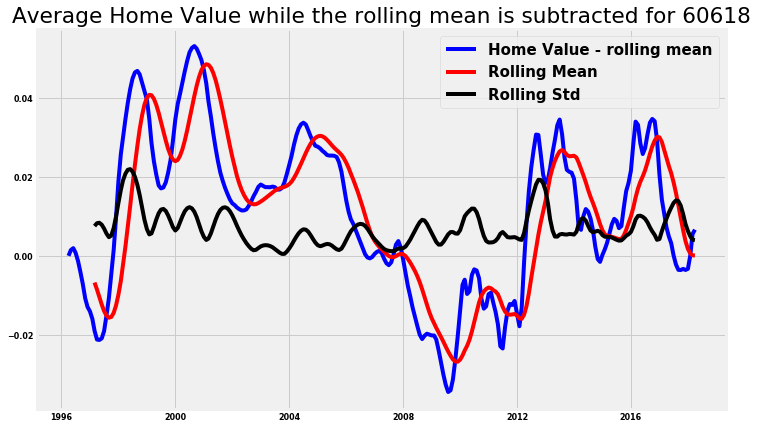

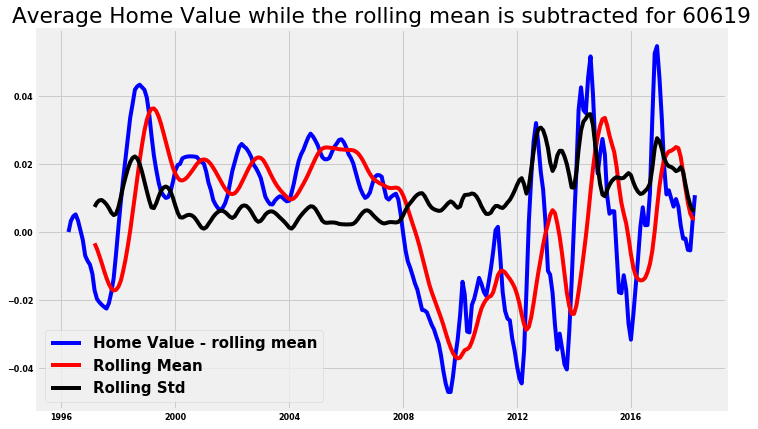

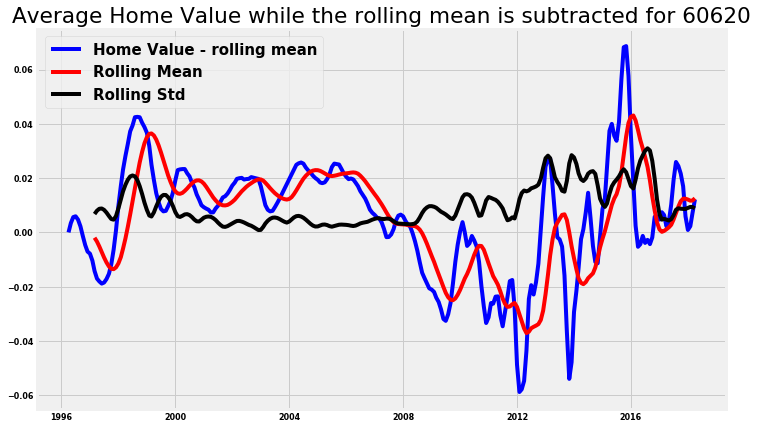

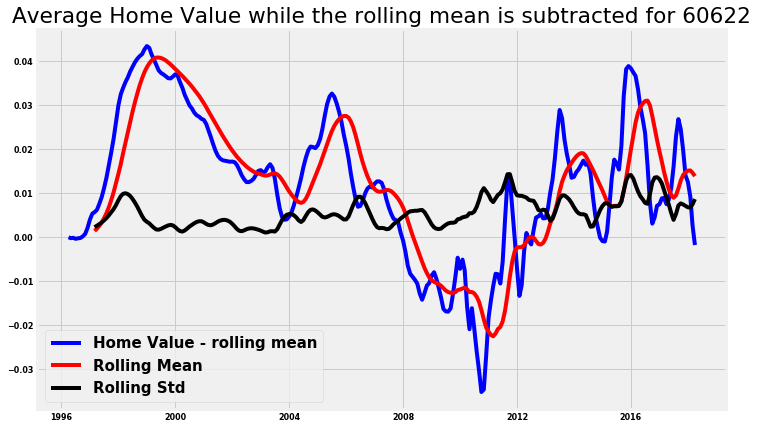

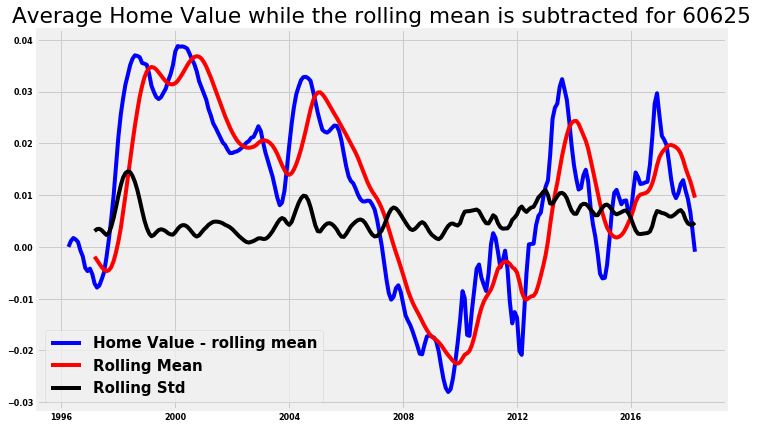

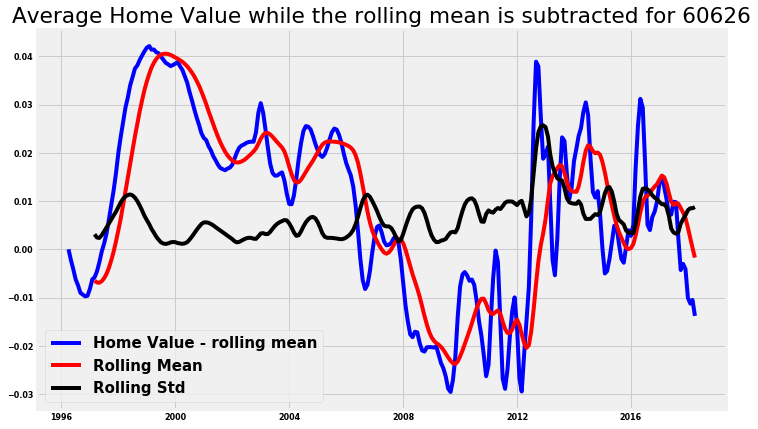

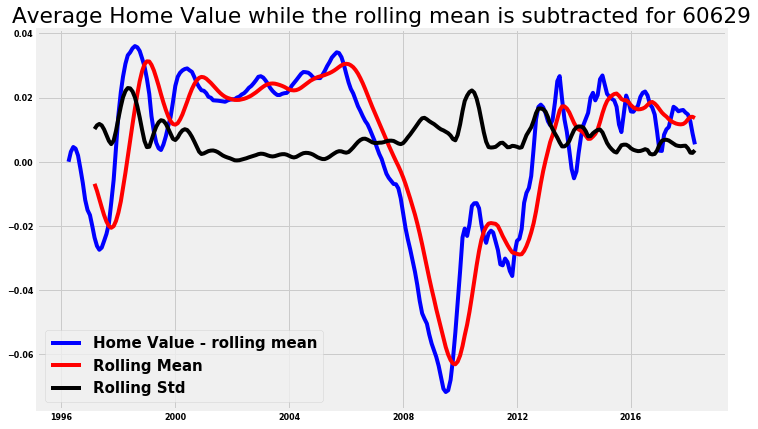

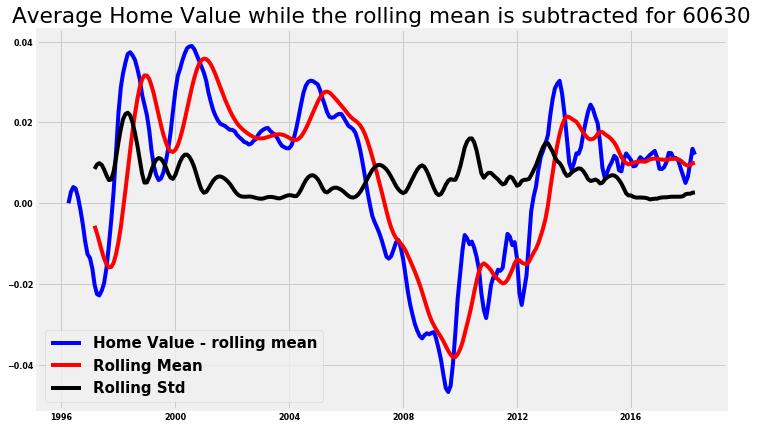

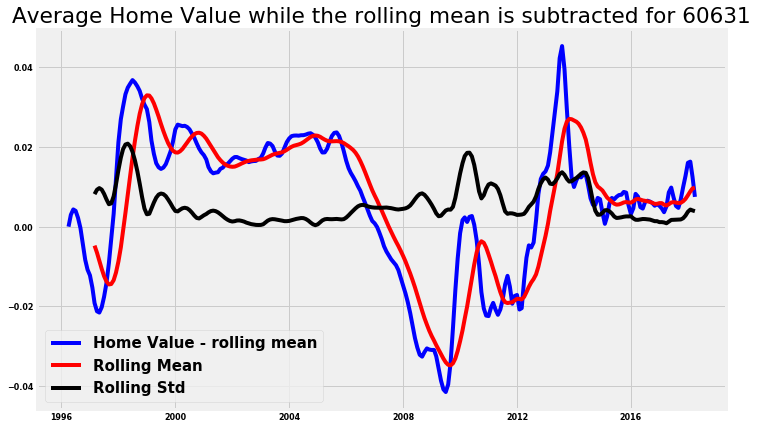

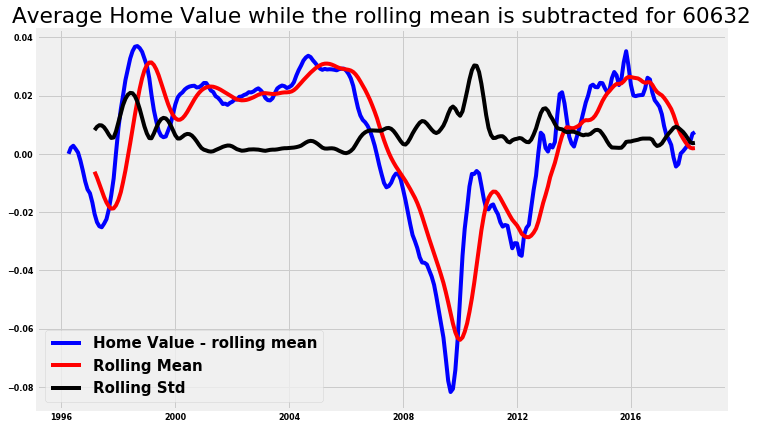

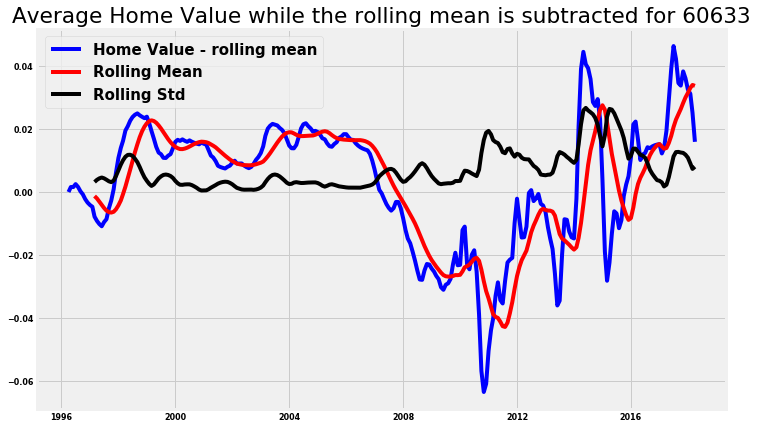

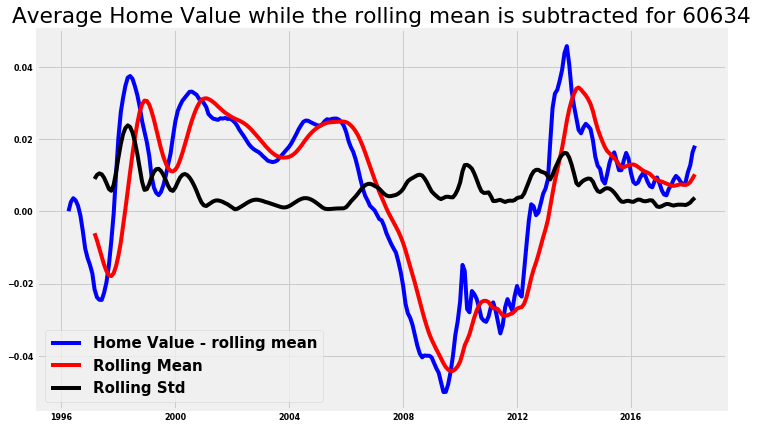

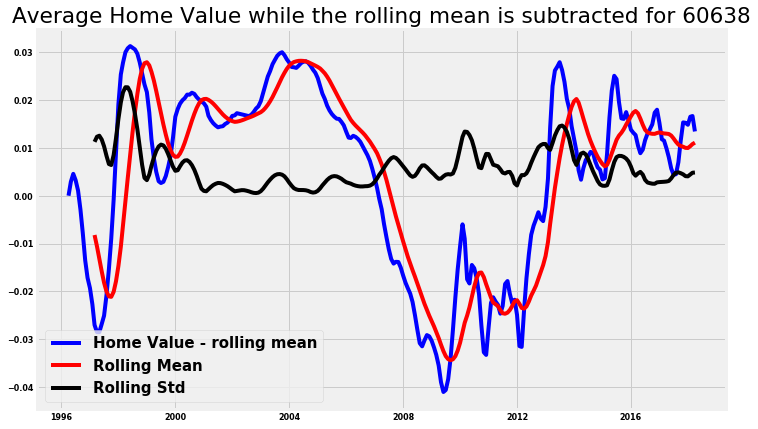

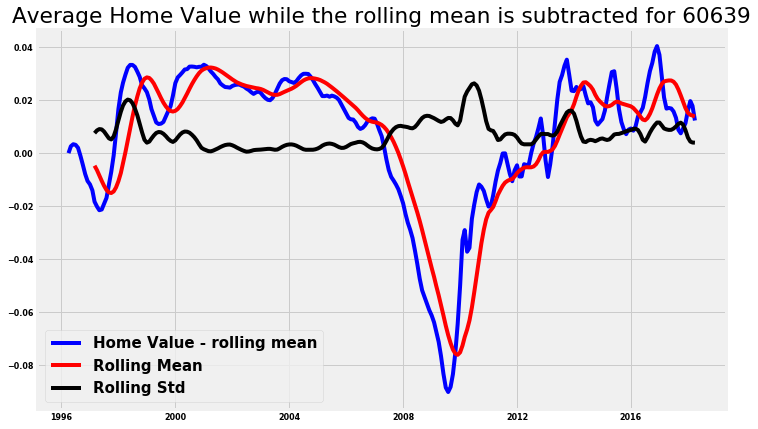

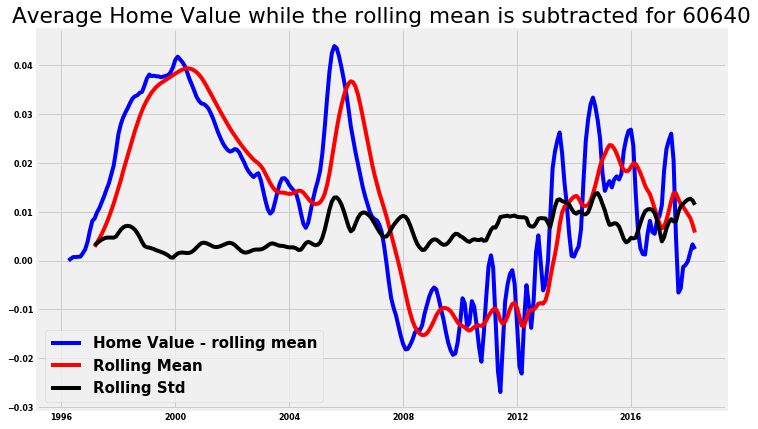

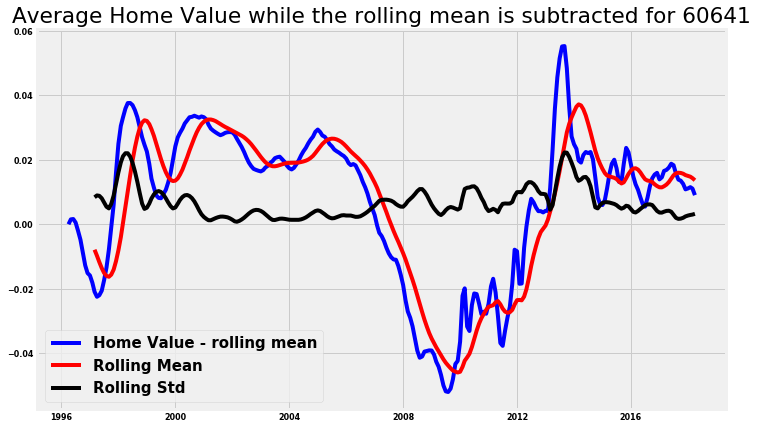

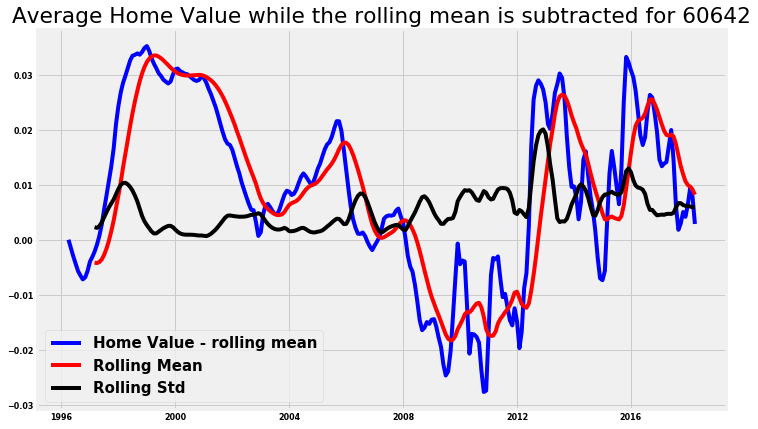

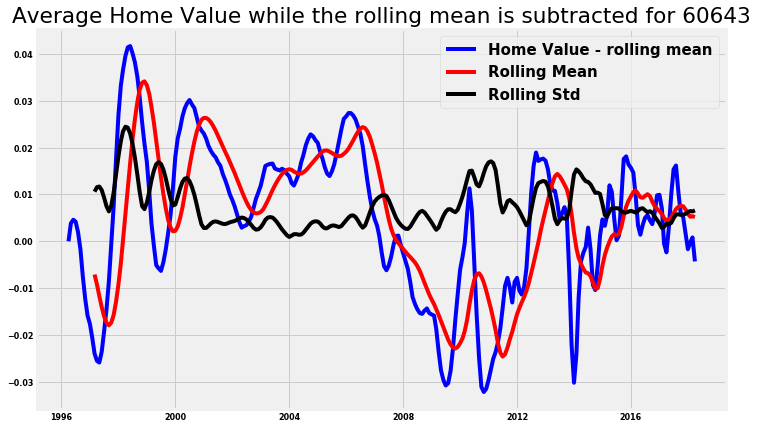

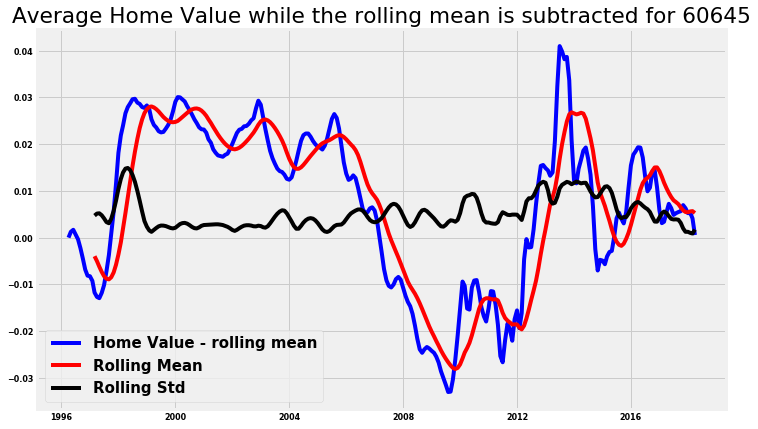

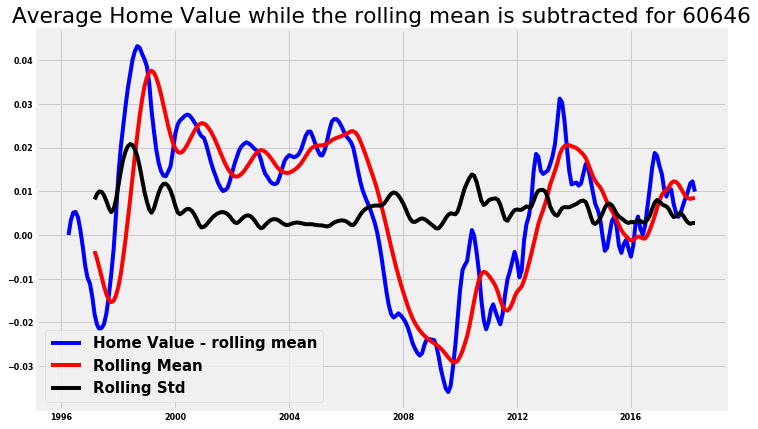

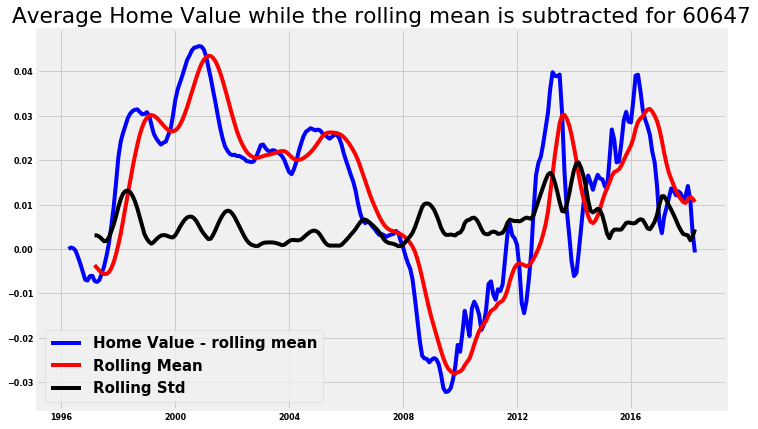

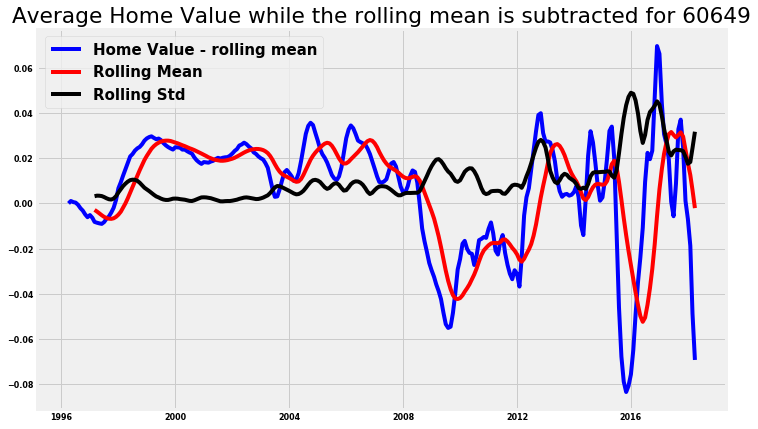

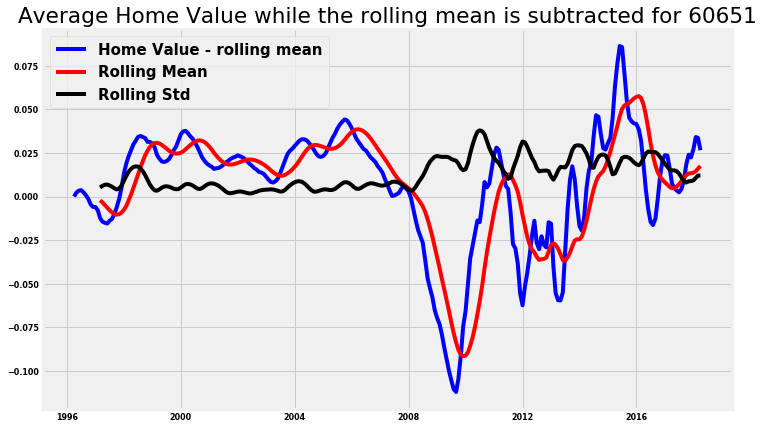

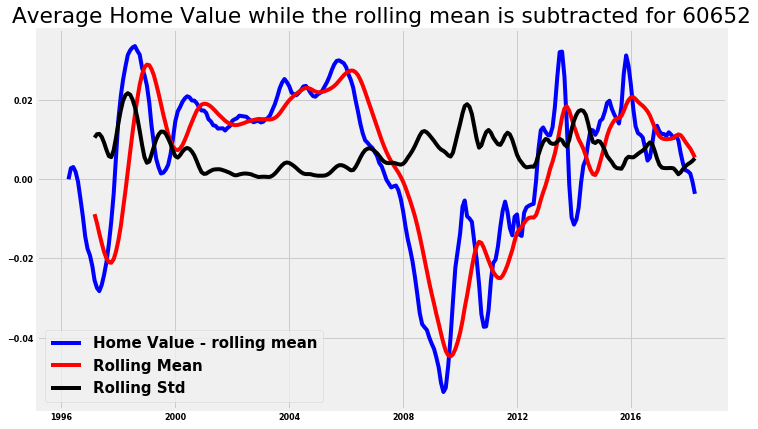

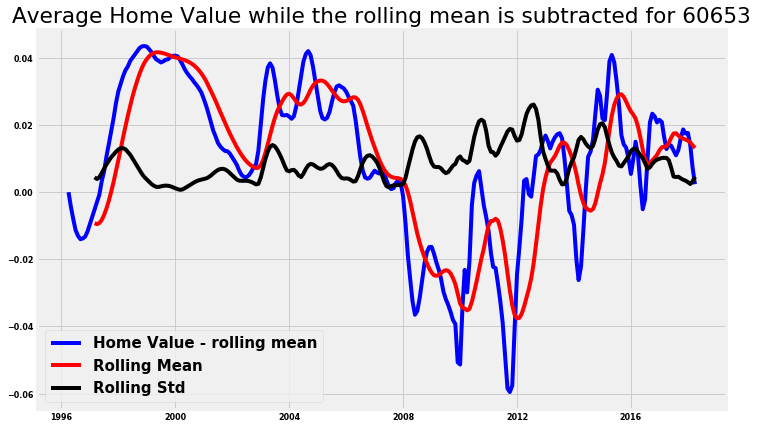

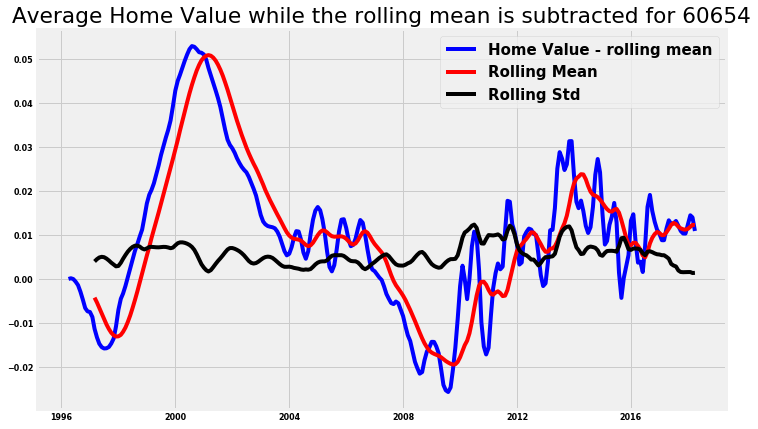

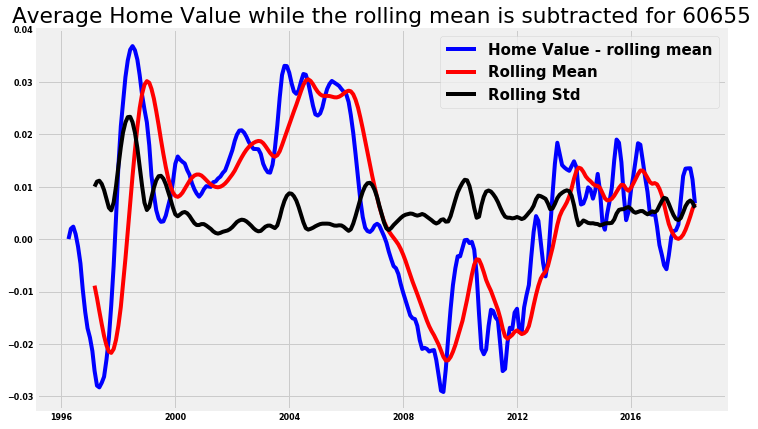

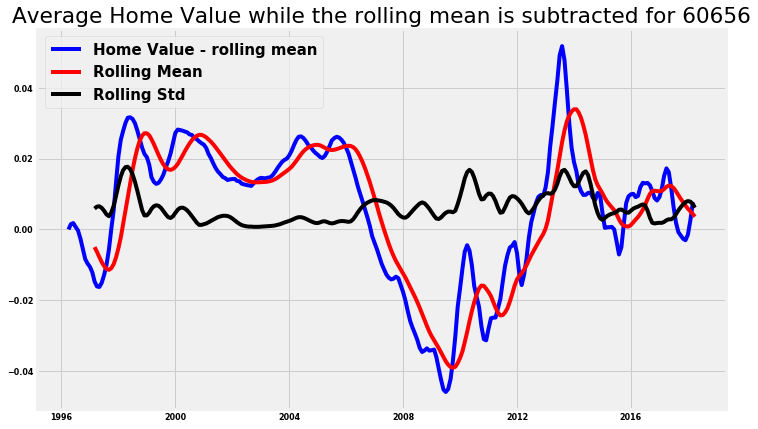

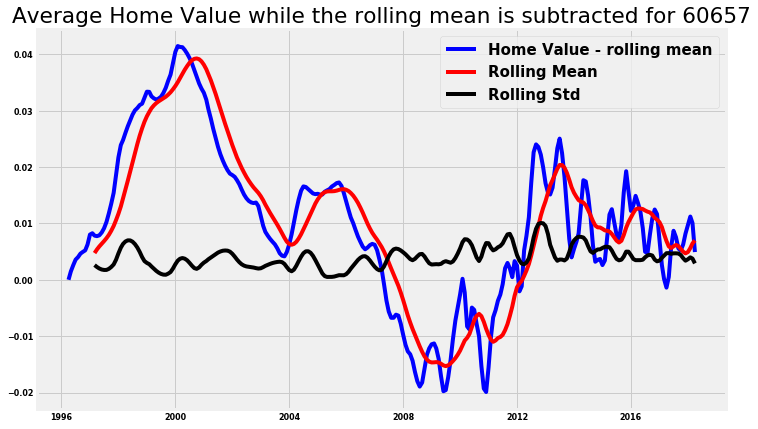

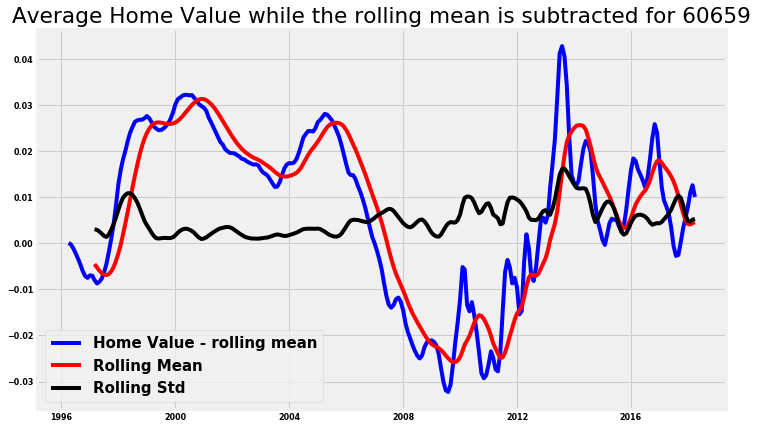

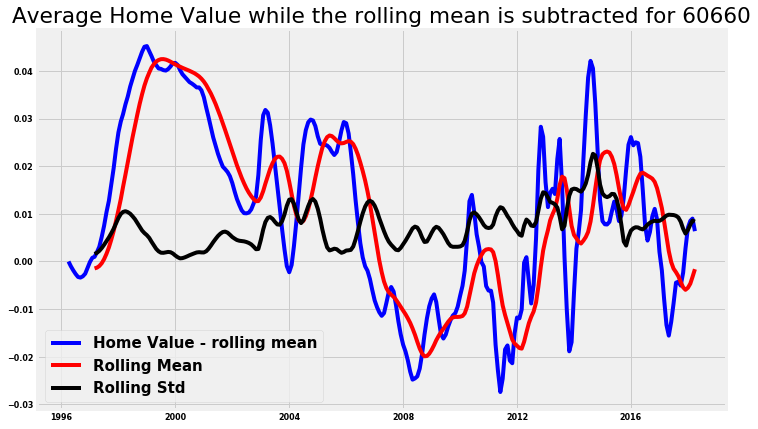

In [16]:
for zipcode in dataframe_dict.keys():
    exp_rolmean = np.log(dataframe_dict[zipcode]).ewm(halflife = 2).mean()

    # Plot the original data with exp weighted average
    data_minus_exp_rolmean = np.log(dataframe_dict[zipcode]) - exp_rolmean
    

    fig = plt.figure(figsize=(11,7))
    plt.plot(data_minus_exp_rolmean, color='blue',label='Home Value - rolling mean')
    mean = plt.plot(data_minus_exp_rolmean.rolling(window = 12, center = False).mean(), color='red', label='Rolling Mean')
    std = plt.plot(data_minus_exp_rolmean.rolling(window = 12, center = False).std(), color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Average Home Value while the rolling mean is subtracted for {zipcode}')
    plt.show(block=False)

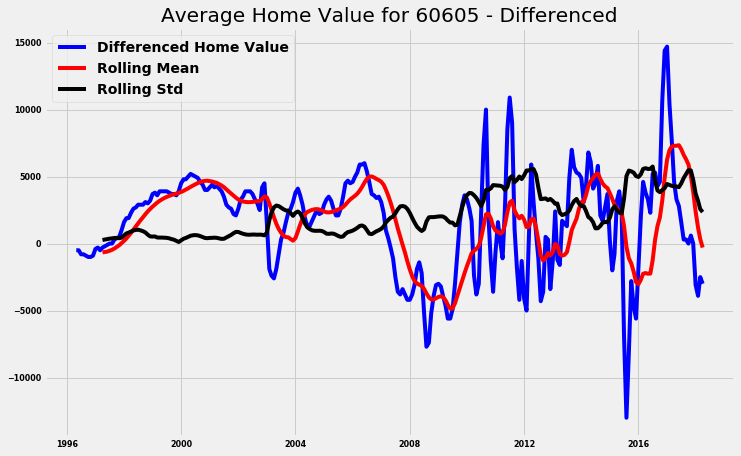

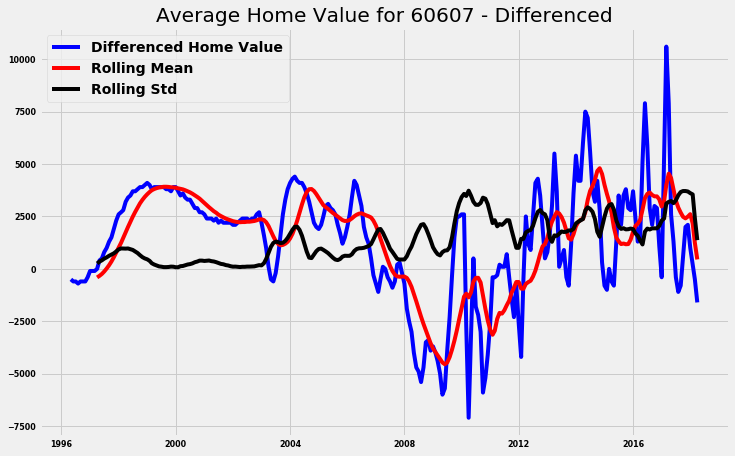

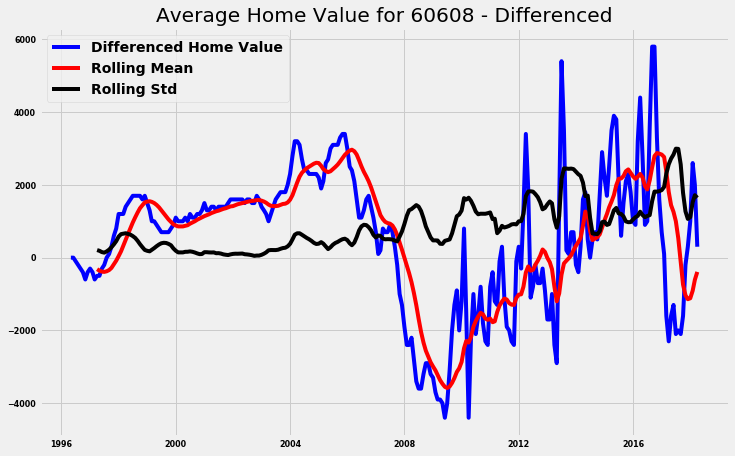

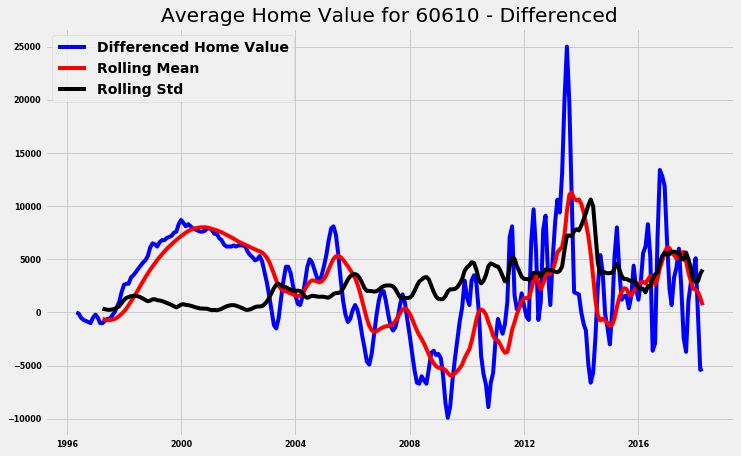

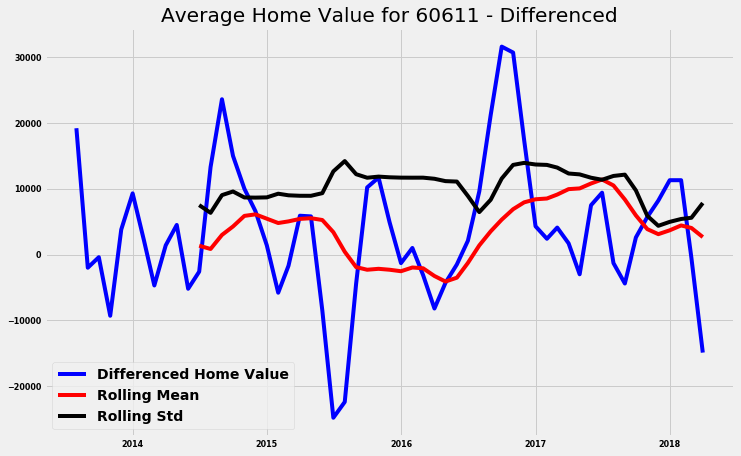

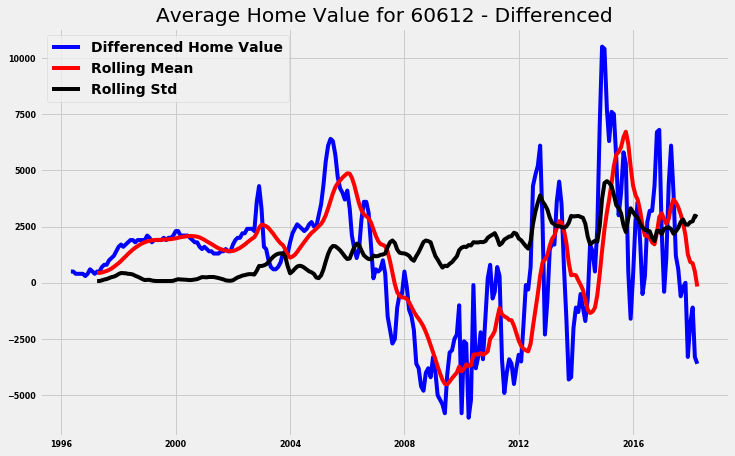

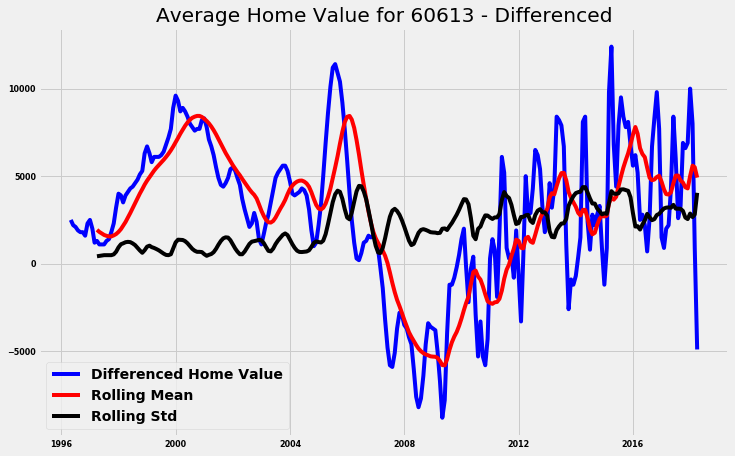

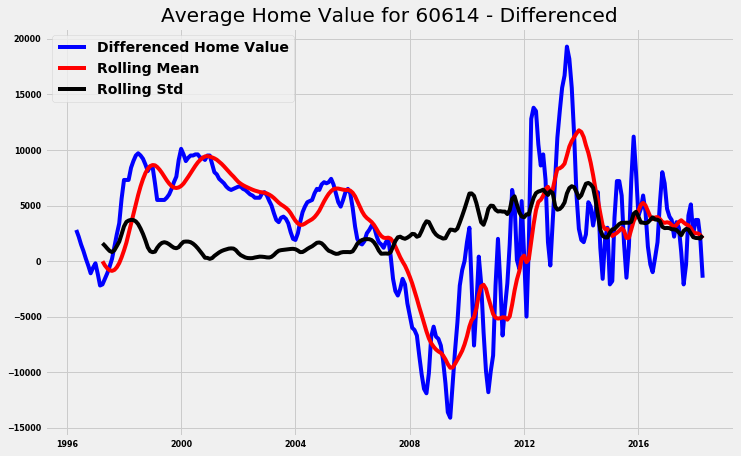

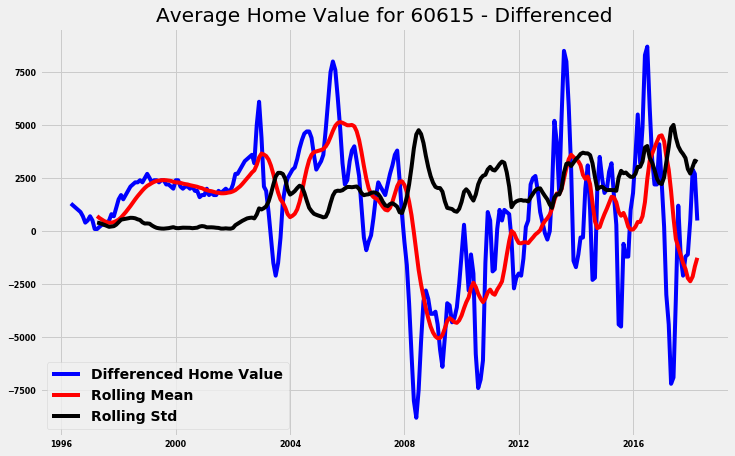

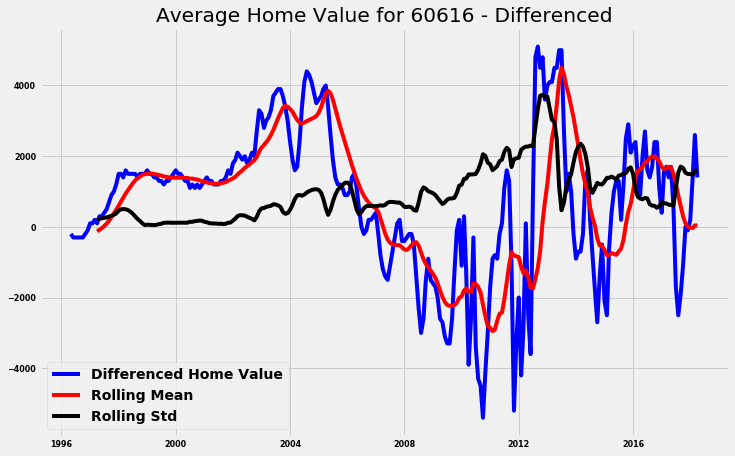

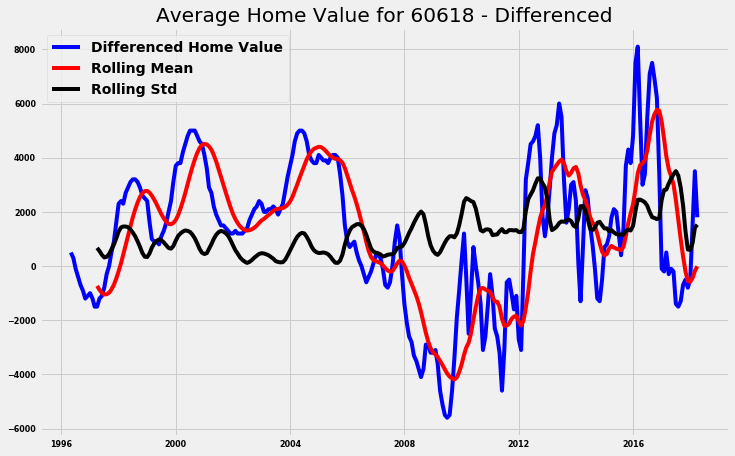

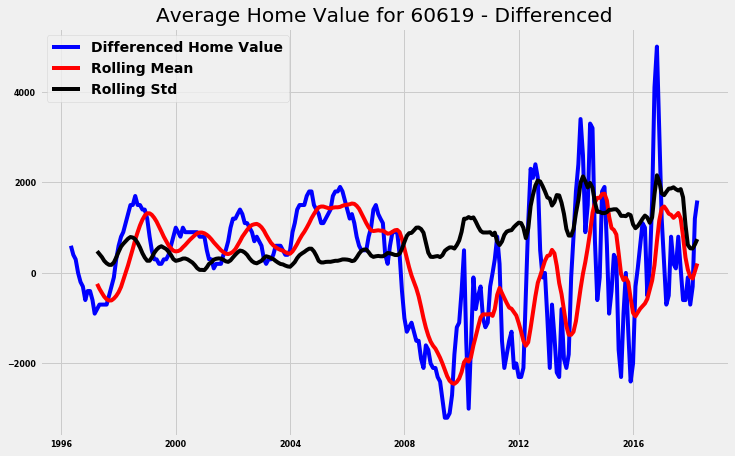

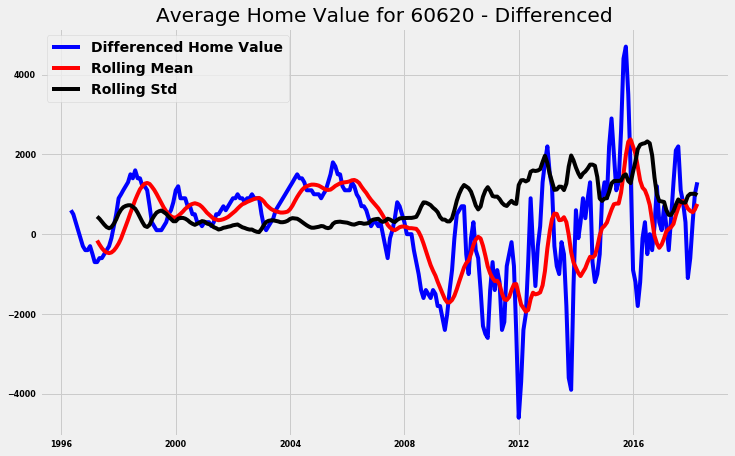

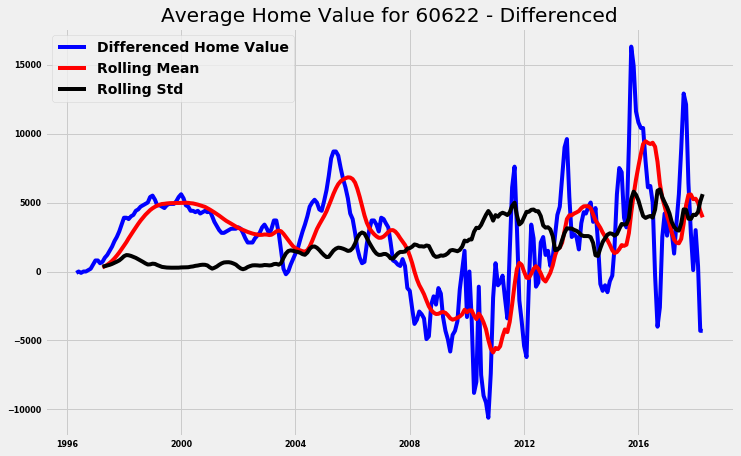

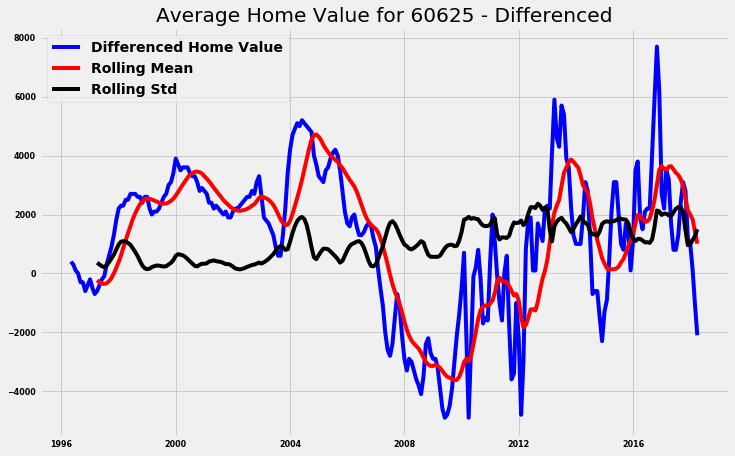

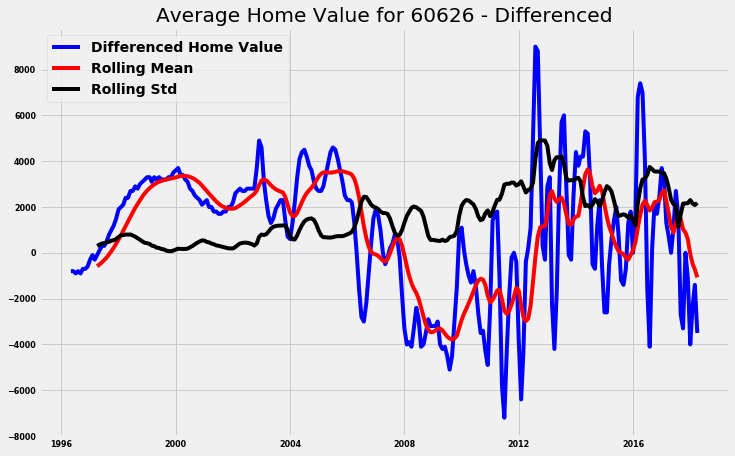

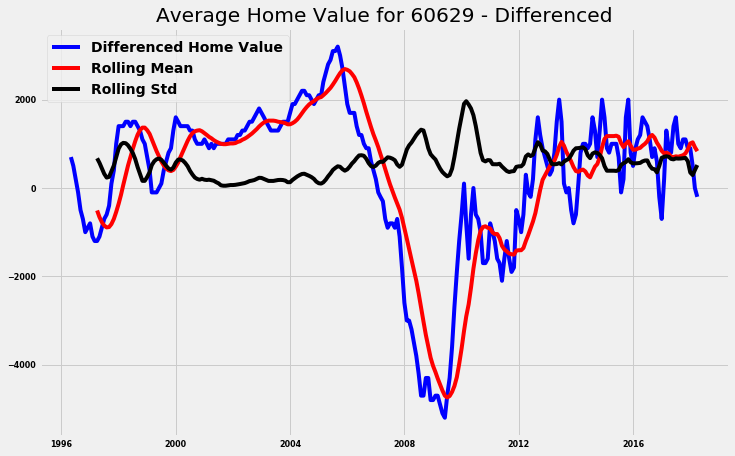

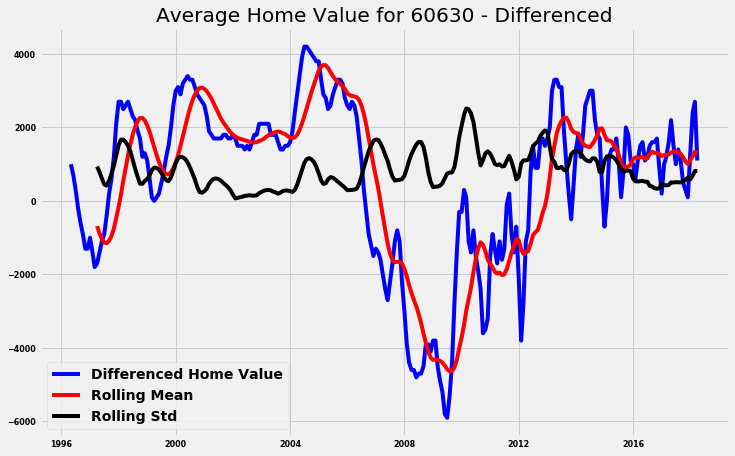

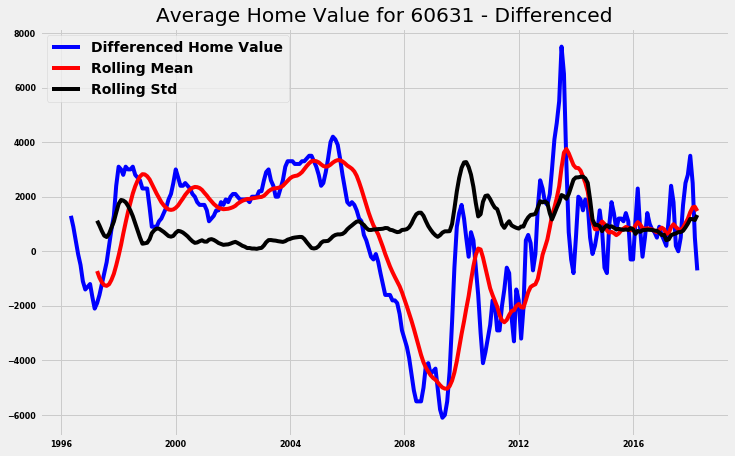

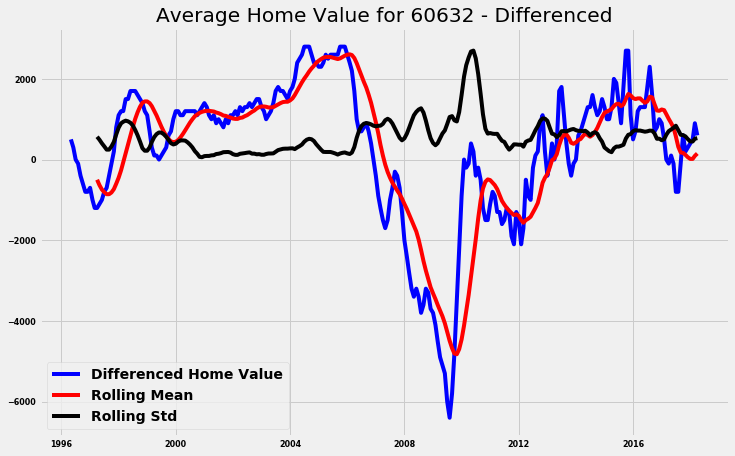

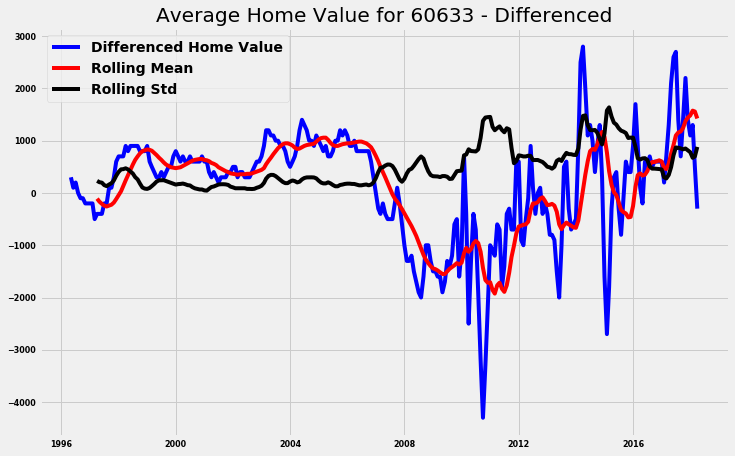

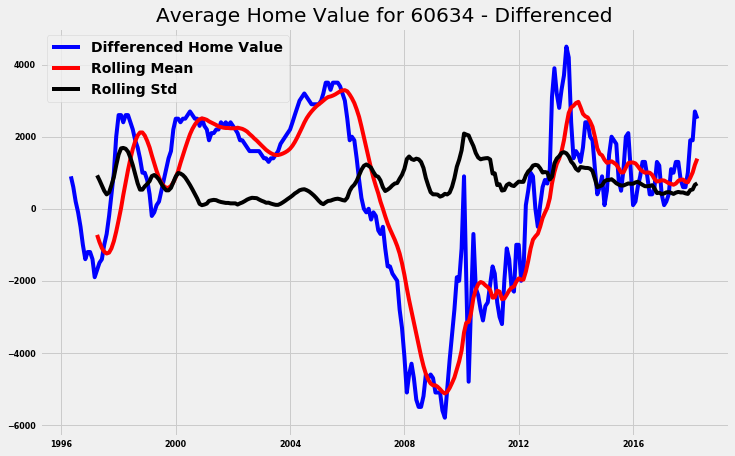

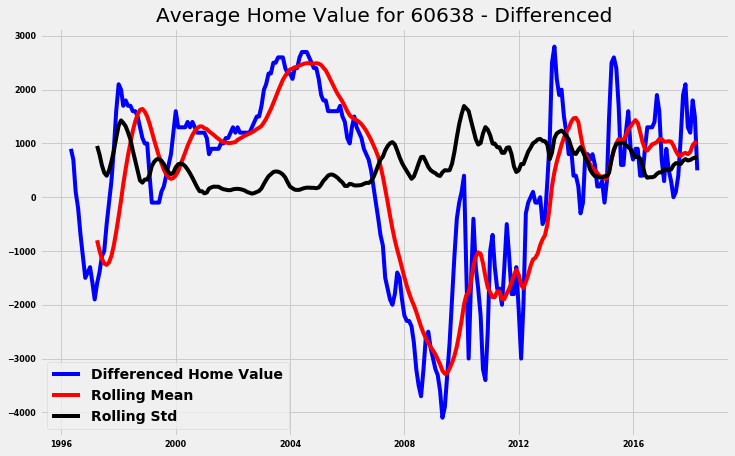

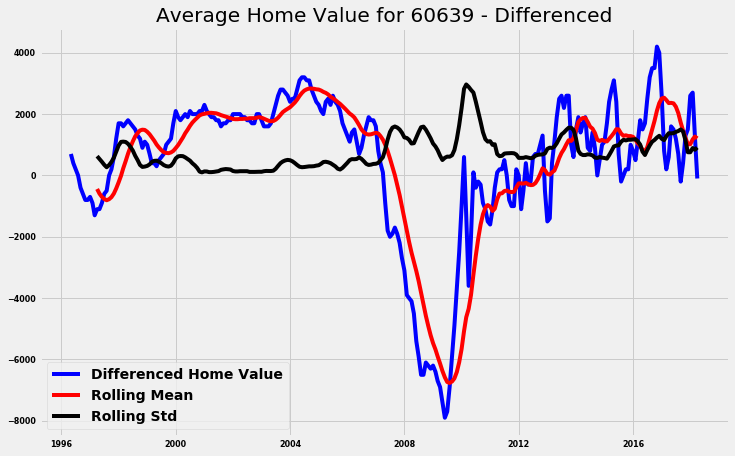

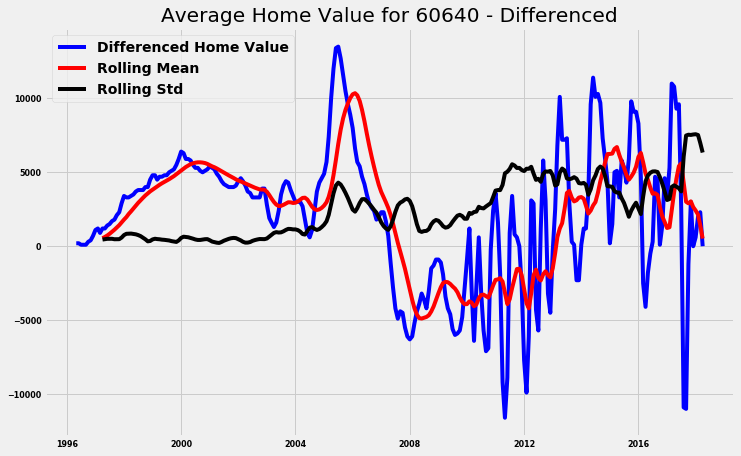

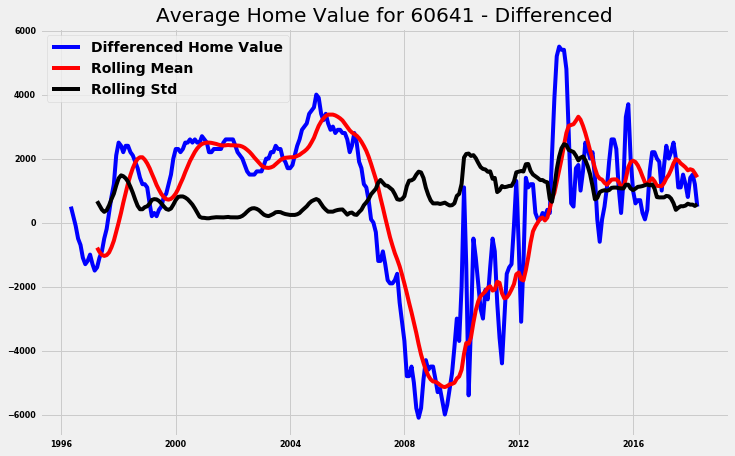

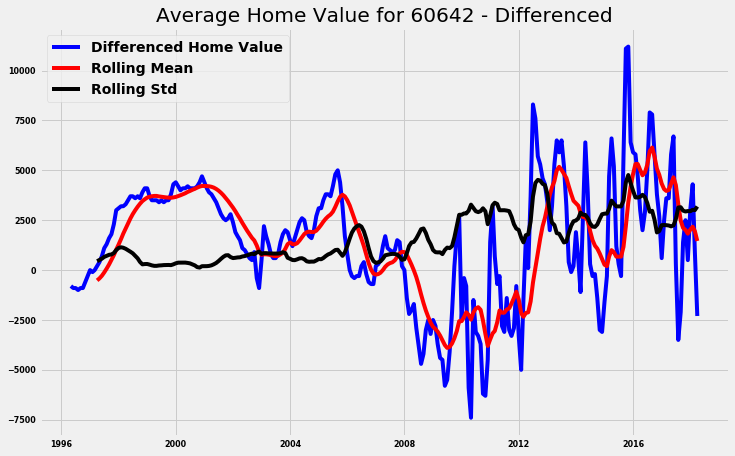

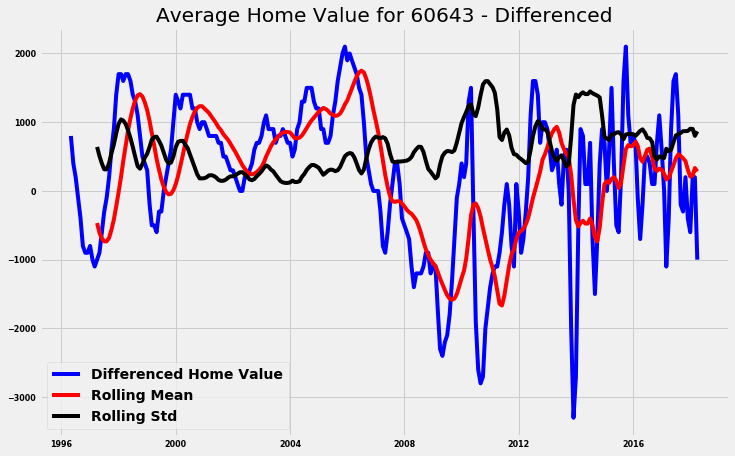

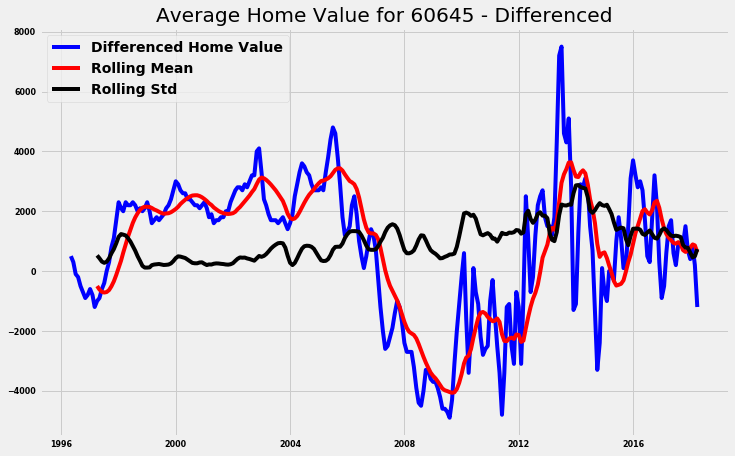

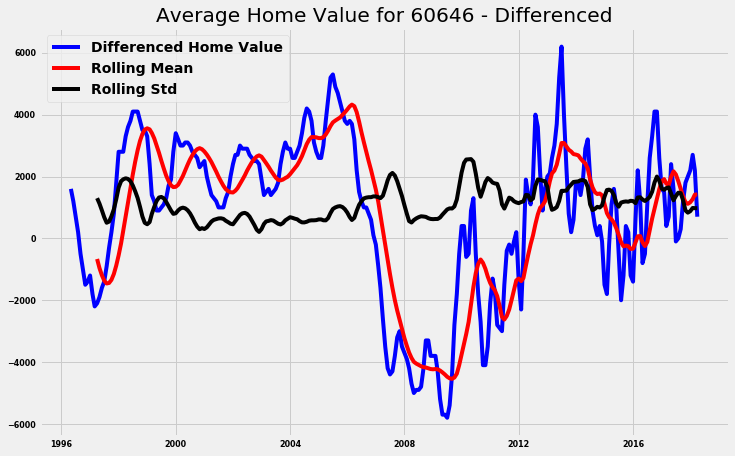

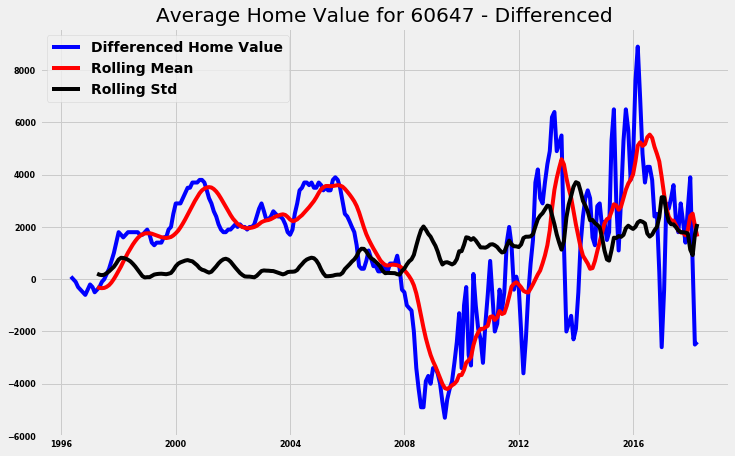

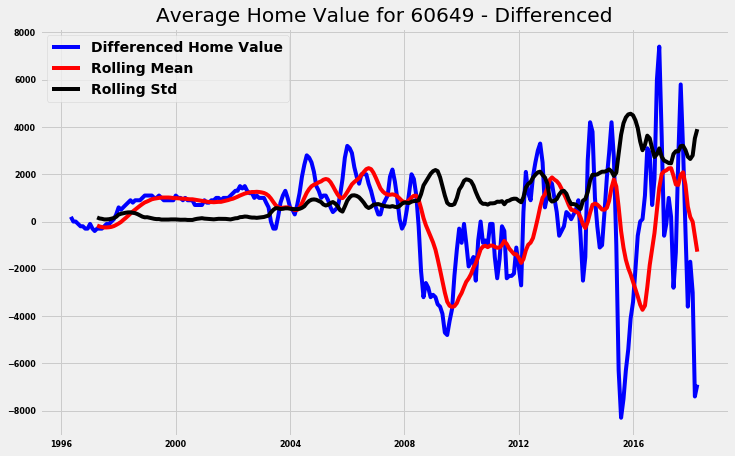

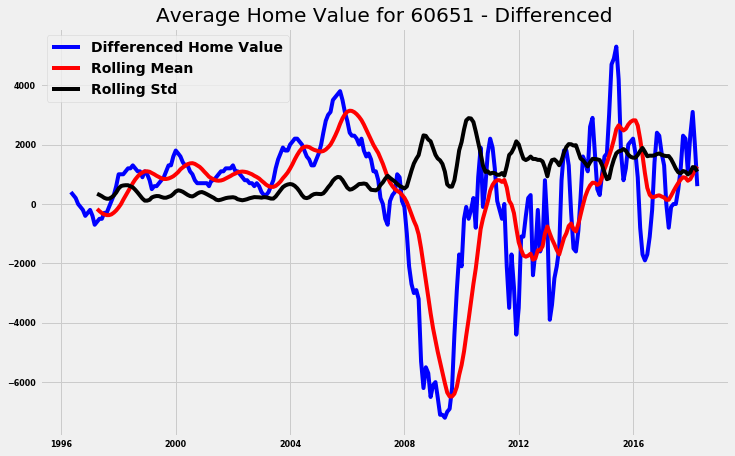

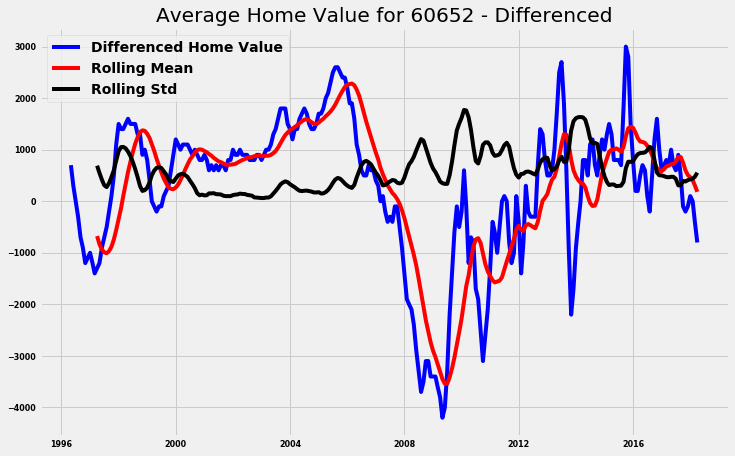

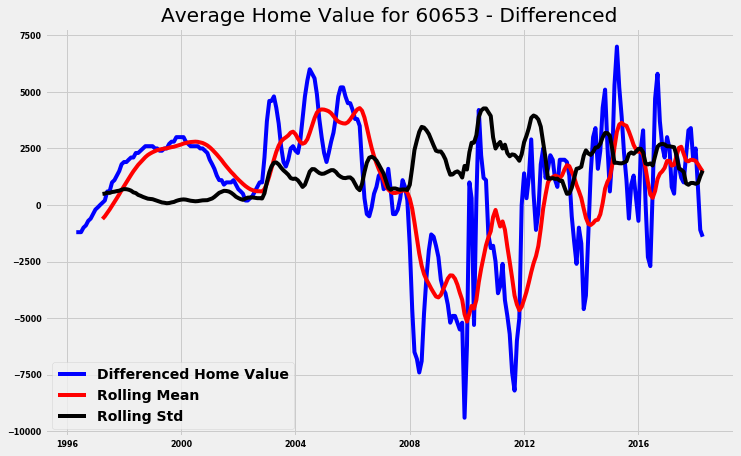

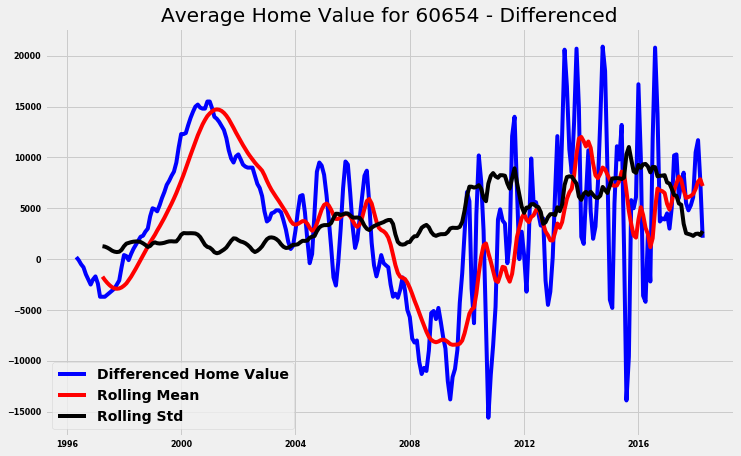

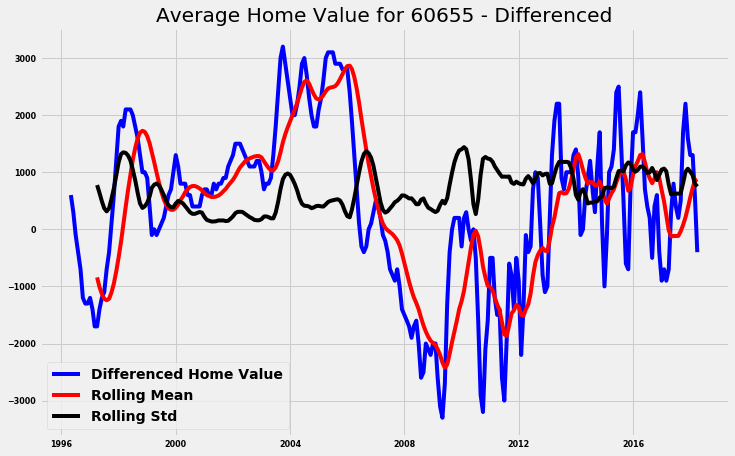

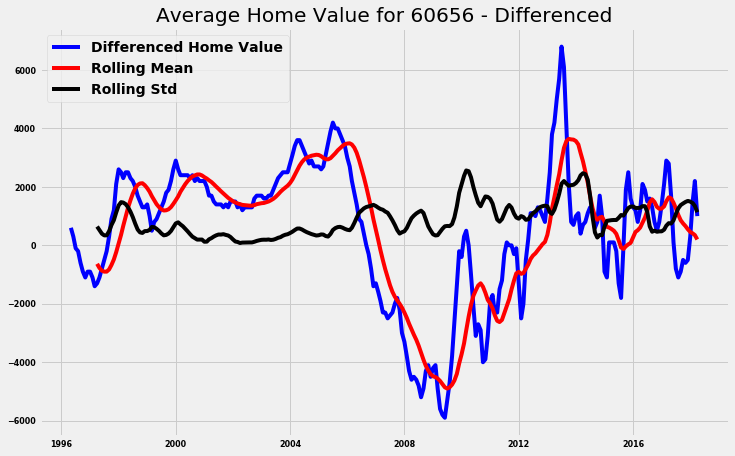

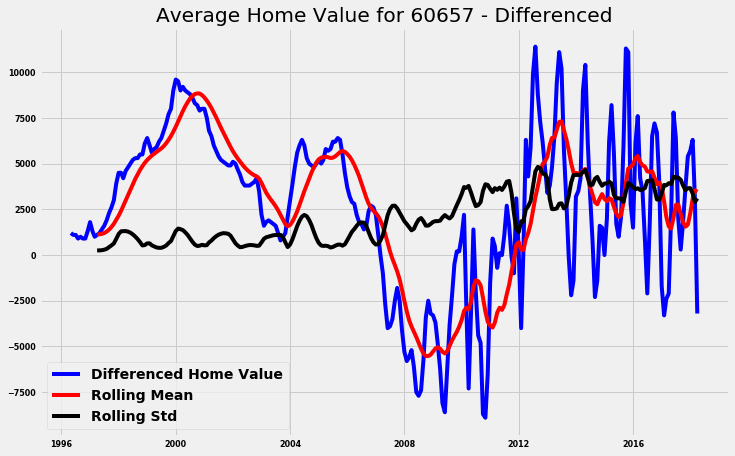

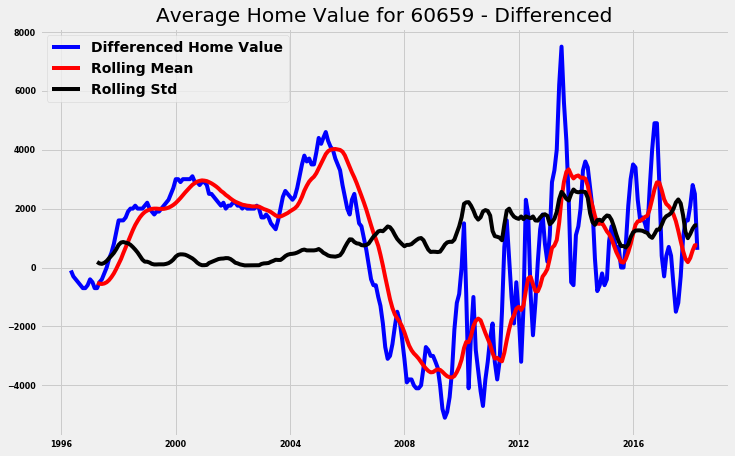

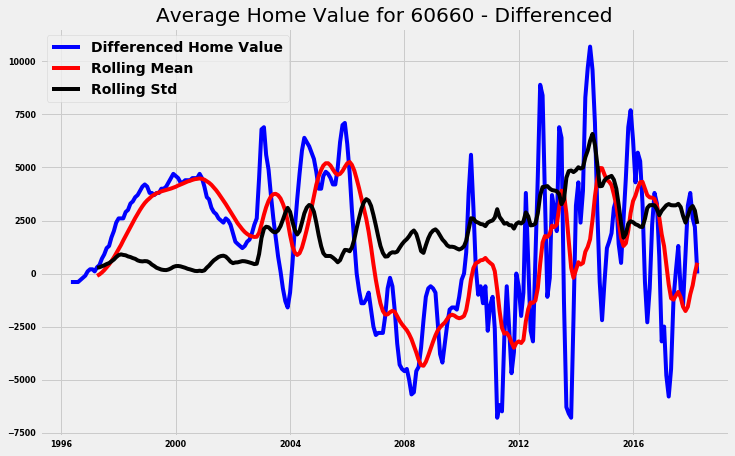

In [50]:
for zipcode in dataframe_dict.keys():
    differenced_zip = dataframe_dict[zipcode].diff().dropna()
    fig = plt.figure(figsize=(11,7))
    plt.plot(differenced_zip, color='blue',label='Differenced Home Value')
    mean = plt.plot(differenced_zip.rolling(window = 12, center = False).mean(), color='red', label='Rolling Mean')
    std = plt.plot(differenced_zip.rolling(window = 12, center = False).std(), color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title(f'Average Home Value for {zipcode} - Differenced')
    plt.show(block=False)

# Step 5: ARIMA Modeling

## Example Log Zipcode Model

In [18]:
for zipcode in log_zips.keys():
    log_zips[zipcode] = np.log(log_zips[zipcode])

In [35]:
log_zips.keys()

dict_keys([60605, 60607, 60608, 60610, 60613, 60614, 60622, 60625, 60626, 60629, 60630, 60631, 60632, 60634, 60638, 60639, 60640, 60641, 60642, 60643, 60645, 60646, 60647, 60653, 60654, 60655, 60656, 60657, 60659, 60660])

In [19]:
import itertools 

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [40]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_zips[60608]["2008":],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False
                                            )
            results = mod.fit()
            #lowest_AIC[zipcode] = 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, np.abs(results.aic).min())
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, np.abs(results.aic).min()))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:966.4659019316225
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:872.583563901456
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:189.5172525470307
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:248.4355395916743
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:189.30899335084874
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:238.81367335426174
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:262.68955526716815
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:262.7827776377064
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:797.2860169256455
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:719.9475020437782
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:335.5691655426739
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:375.7232352278336
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:336.3900788012252
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:380.01751952616024
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:390.4404495545536
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:386.5685263804378
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:747.5142862229661
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:679.8709958750289
ARIMA(0

                            Statespace Model Results                            
Dep. Variable:                    value   No. Observations:                  124
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                  95.759
Date:                  Fri, 11 Oct 2019   AIC                           -189.517
Time:                          17:21:11   BIC                           -186.808
Sample:                      01-01-2008   HQIC                          -188.418
                           - 04-01-2018                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0104      0.002      4.897      0.000       0.006       0.015
Ljung-Box (Q):                     1253.48   Jarque-Bera (JB):                 6.05
Prob(Q):                       

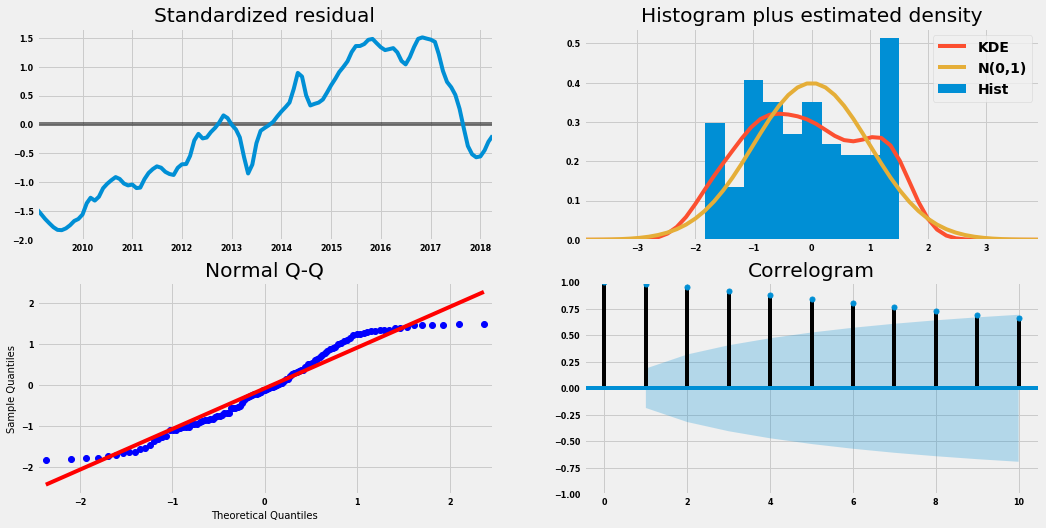

In [51]:
mod = sm.tsa.statespace.SARIMAX(log_zips[60608]["2008":],
                                order=(0, 0, 0),
                                seasonal_order=(0, 1, 0 , 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Example Diff Zipcode Model

In [43]:
for zipcode in diff_zips.keys():
    diff_zips[zipcode] = diff_zips[zipcode].diff().dropna()

In [44]:
diff_zips.keys()

dict_keys([60605, 60611, 60643, 60651])

In [47]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(diff_zips[60605]['2008':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False
                                            )
            results = mod.fit()
            #lowest_AIC[zipcode] = 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, np.abs(results.aic).min())
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, np.abs(results.aic).min()))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2434.9667622289644
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2199.5067412017156
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2292.3592052558865
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2005.8320905738142
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2218.997523212816
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2201.0100011933637
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2042.6495785605193
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1987.4263579082142
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2312.3131698758693
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2082.998689209025
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2181.9950229754963
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1910.6415495281876
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2120.8316463413867
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2089.346217048301
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1968.2274299380838
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1880.3738995979081
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2284.3655965142807
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2058.477171155

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  124
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 337.517
Date:                            Fri, 11 Oct 2019   AIC                           -667.033
Time:                                    17:16:40   BIC                           -656.734
Sample:                                01-01-2008   HQIC                          -662.869
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0451      0.055     19.091      0.000       0.938       1.152
ar.S.L12      -0.1980      0.189   

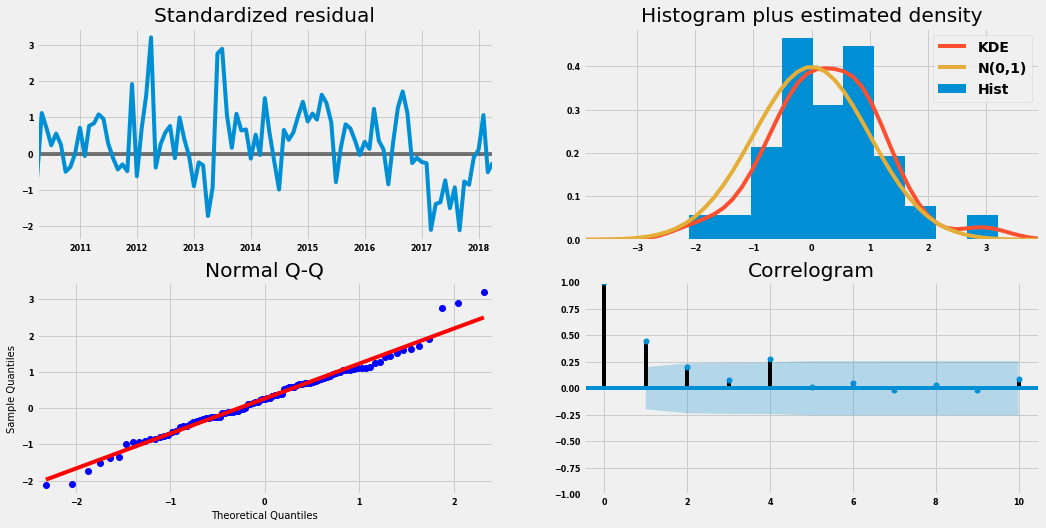

In [49]:
#ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1824.1985352088907
mod = sm.tsa.statespace.SARIMAX(log_zips[60608]["2008":],
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## 60608 Differenced instead of Log Transformed

In [57]:
_60608_diff = dataframe_dict[60608].diff().dropna()

In [58]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(_60608_diff['2008':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False
                                            )
            results = mod.fit()
            #lowest_AIC[zipcode] = 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, np.abs(results.aic).min())
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, np.abs(results.aic).min()))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2256.3449241216395
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2017.1849881784065
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2063.9329976762656
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1824.657070211742
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2033.477729311693
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2016.130810016981
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1853.4824908334983
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1825.5996137684033
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2120.6554191561527
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1882.5059889129536
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1935.3074845057533
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1704.0797847697615
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1915.7727664355634
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1881.5483763231066
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1753.039575175573
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1698.7558028931758
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2084.8156899697706
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1888.8102567254

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  124
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -822.570
Date:                            Fri, 11 Oct 2019   AIC                           1651.140
Time:                                    17:25:40   BIC                           1658.864
Sample:                                01-01-2008   HQIC                          1654.263
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7734      0.065     11.813      0.000       0.645       0.902
ma.S.L12      -1.0182      0.795   

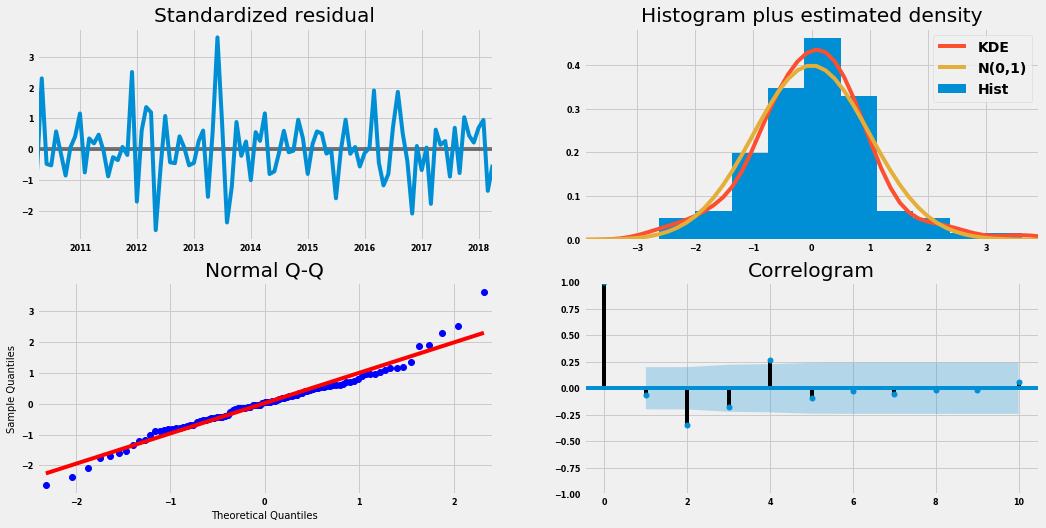

In [59]:
mod = sm.tsa.statespace.SARIMAX(_60608_diff["2008":],
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Step 6: Interpreting Results